In [1]:
import math
import numpy as np
import pandas as pd
import sys
import itertools
from functions import *
from mining_functions import *
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

In [3]:
df2 = df.copy()
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)


In [4]:
merge_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_discrete(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    ymax= max(max(freq_HL),max(freq_LL))
    bins = range(0,int(ymax)+1,1)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def make_hist_continuous(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    bins = np.arange(0,1.05,0.05)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def get_frequencies(seq_of_interest,blocks1,blocks2,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
    return freq1.values(),freq2.values()

def run_chi2(seq_of_interest,blocks1,blocks2,consider_if=None):
    def coo(seq, seq_of_interest):
        if occurrences("".join(seq),seq_of_interest) >=1:
            return 1
        else:
            return 0
        
    if consider_if:
        hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
        nhl = sum([coo(seq, consider_if) for student,seq in blocks1.iteritems()])-hl
        ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
        nll = sum([coo(seq, consider_if) for student,seq in blocks2.iteritems()])-ll
    else:
        hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
        nhl = len(blocks1.keys())-hl
        ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
        nll = len(blocks2.keys())-ll
    
    to_print = [["","Low-High","Low-Low","total"]]
    to_print.append(["used it",hl,ll,ll+hl])
    to_print.append(["didn't use it",nhl,nll,nll+nhl])
    to_print.append(["total",nhl+hl,nll+ll,nll+ll+nhl+hl])
    print tabulate(to_print)
    
    total = float(hl + nhl + ll + nll)
    print stats.chisquare(f_obs= [hl,ll],   # Array of observed counts
                    f_exp= [(hl+nhl)*(hl+ll)/total,(ll+nll)*(hl+ll)/total])   # Array of expected counts
    return None
# ### Demonstration of function above
# b1 = {1:["A","Bo","C","Bo","C","A","C","A"]}
# b2 = {3:["A","Bo","C","Bo","A","Bo","A","Bo"]}
# f1,f2 = get_frequencies('BoC',b1,b2,normalize_by='Bo')
# print f1,f2

def perform_comparative_stats(seq_of_interest,freq1,freq2):
    t,p =  stats.ttest_ind(freq1,freq2,equal_var=False)
    print seq_of_interest,':'
    print "\tT-test:\t{0} \t p={1}".format(round(t,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='less')
    print '\tHL<LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='greater')
    print '\tHL>LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    
# def remodel_families_lightbulb(row):
#     if row["Family"] == "Test_complex":
#         if row['current_#lightBulb']>0:
#             if row["current_#battery"] == 1: 
#                 #we have a simple circuit ;)
#                 if row["current_#loops"] == 1:
#                     if row["current_#resistor"] == 0: #basic circuit!
#                         return 'Test_series_l'
#                     if row["current_#resistor"] == 1: #basic circuit!
#                         return 'Test_series_l_r'
#                     if row["current_#resistor"] == 2: #basic circuit!
#                         return 'Test_series_l_r_r'
#                 elif row["current_#loops"] == 2:
#                     if row["current_#resistor"] == 0: #basic circuit!
#                         return 'Test_parallel_l'
#                     if row["current_#resistor"] == 1: #basic circuit!
#                         return 'Test_parallel_l_r'
#                     if row["current_#resistor"] == 2: #basic circuit!
#                         return 'Test_parallel_l_r_r'
#     return row["Family"]
# df2 = df.copy()
# df2['Family'] = df2.apply (lambda row: remodel_families_lightbulb (row),axis=1)

# blocks_HL_lightbulb, time_coords_HL =  get_blocks_withTime_new(df2,students_HL,"Family",start=False,ignore=['I'], as_list=True)
# blocks_LL_lightbulb, time_coords_LL =  get_blocks_withTime_new(df2,students_LL,"Family",start=False,ignore=['I'], as_list=True)

# Story line
This notebook raises and explores hypotheses generated fom the analysis in the notebook  "temporal_sequence_infogain_mining.ipynb"

Here are the Hypotheses:
* CTsPTsP (HL)
    * TsP
        * Ts (**1.1**)
        * TP (**1.2**)
    * TsPTsP
        * TPTP (**2.1**)
* PCTcCTcC (LL)
    * TcC
        * Tc (**3.1**)
        * TC (**3.2**)
    * TcCTcC
        * TCTC (**4.1**)
* PCPCTcC (LL)
    * PC (**5.1**)
    * CP (**5.2**)
* PTsPC (HL)
    * PTs
    * PT (**6**)


# Frequency analysis of single blocks of actions -> Hypotheses 1.1 and 3.1
First we get the sequence of action of each students in blocks. Recall that we only look at students who had a low pre.
We also ignore the Interface actions becasue they aren't interesting.

In [5]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
print "There are {0} low pre students, of which {1} are high learners and {2} low learners.".format(len(students_Lpre),len(students_HL),len(students_LL))

There are 74 low pre students, of which 38 are high learners and 36 low learners.


In [6]:
blocks_HL, time_coords_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I'], as_list=True)
blocks_Lpre, time_coords_Lpre =  get_blocks_withTime_new(df,students_Lpre,"Family",start=False,ignore=['I'], as_list=True)
blocks_merged_HL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_HL.iteritems()}
blocks_merged_LL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_LL.iteritems()}
blocks_merged_Lpre = {student:[merge_actions[s] for s in seq] for student,seq in blocks_Lpre.iteritems()}
actions_merged = ['C','P','T']
actions_all = ['C', 'P', 'Tb', 'Tc', 'Ts']

We may need to plot sequences so let's load them up

In [7]:
CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 10
B = 4  #number of bins
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students_Lpre,family_category,
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


First we need to check that students tend to do the same number of blocks of actions in their sequences

77882125 1363826633350 1363824270620 2362.73000002


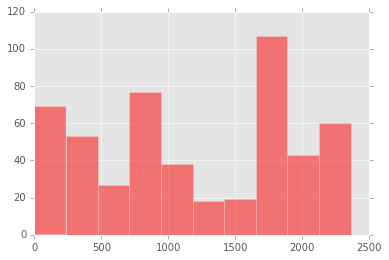

8889108 1373578385593 1373576259108 2126.4849999


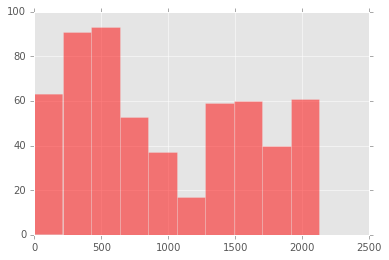

48107113 1373578354382 1373576422045 1932.33699989


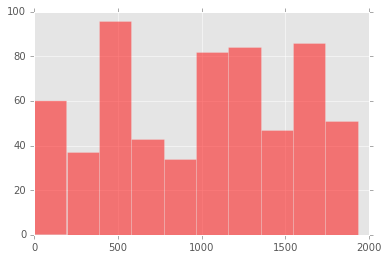

12235124 1363826233223 1363824186176 2047.04699993


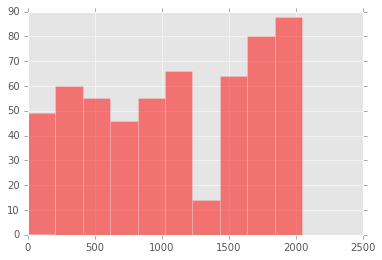

12949120 1363891454532 1363889236140 2218.39199996


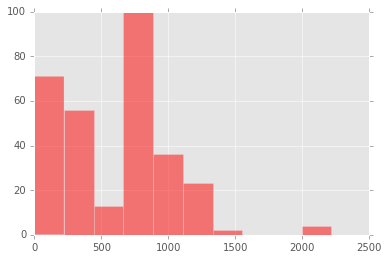

18088102 1373578383390 1373576344156 2039.23400021


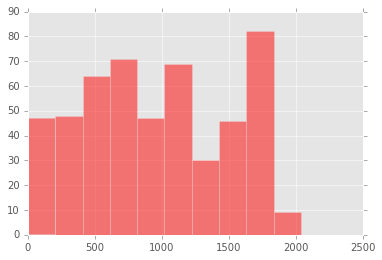

10942128 1363826953746 1363824283754 2669.9920001


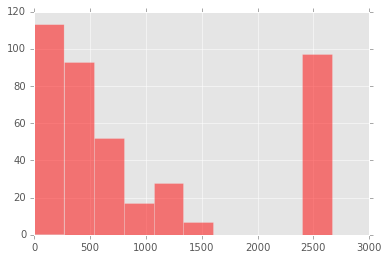

35155125 1363826708735 1363824338208 2370.52699995


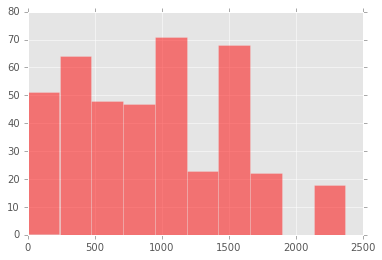

3591123 1363826936500 1363824309312 2627.18799996


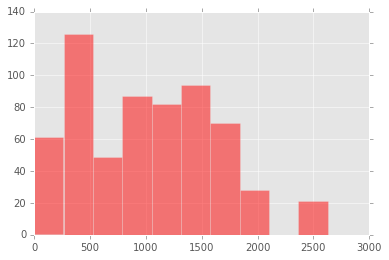

67899116 1373652544734 1373650094625 2450.10899997


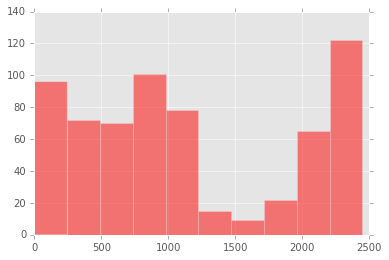

82885110 1373578391695 1373576420382 1971.31299996


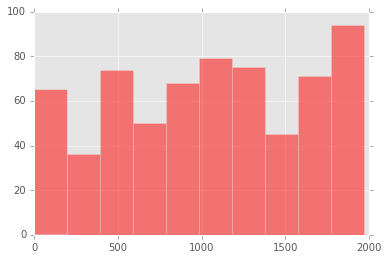

11


In [8]:
i=0
for student in students_Lpre:
    if  (max(df[df['student']==student]['Time Stamp'])-min(df[df['student']==student]['Time Stamp']))/1000.0>1920:
        print student, max(df[df['student']==student]['Time Stamp']),min(df[df['student']==student]['Time Stamp']),            max(df[df['student']==student]['Time Stamp'])/1000.0-min(df[df['student']==student]['Time Stamp'])/1000.0
        data = df[df['student'] == student]['Time Stamp']
        plt.hist([(x-min(data))/1000.0 for x in data],color ='r',alpha = 0.5)
        plt.show()
        plt.clf()
        i+=1
print i

In [9]:
(1363633621086-1363630968179)/1000.00

2652.907

4762120 1363826104818 1363824569895 1534.9230001


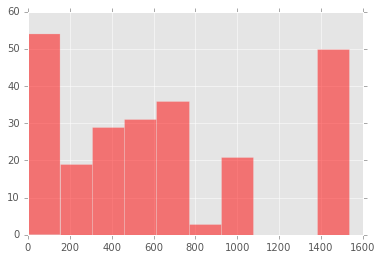

68995094 1373408862242 1373407259633 1602.60900021


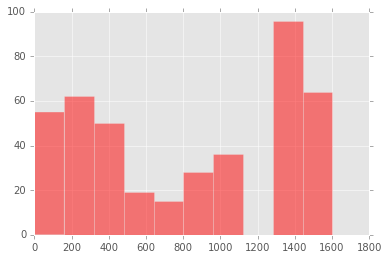

89337123 1373577805108 1373576400920 1404.18799996


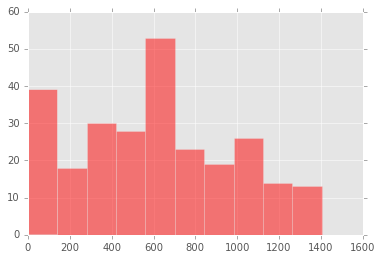

82616120 1020402939578 1020401942453 997.125


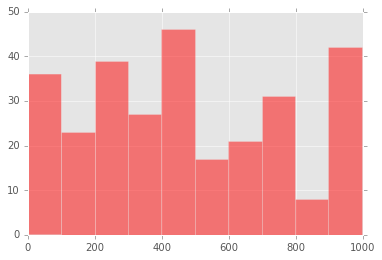

41295172 1363635251320 1363633621086 1630.23399997


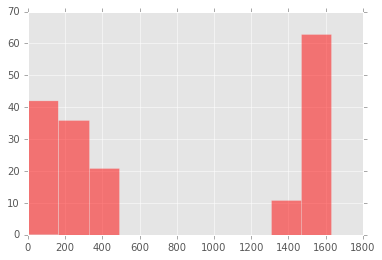

13378139 1373651209261 1373650168073 1041.18799996


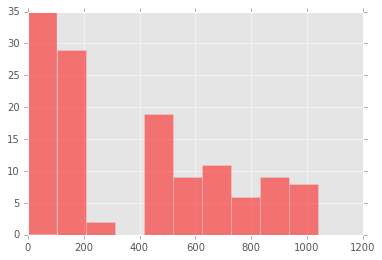

70209120 1363890562796 1363889286984 1275.81200004


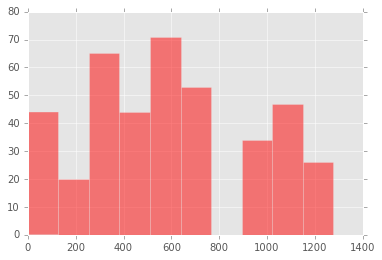

83841128 1363825930540 1363824309898 1620.64199996


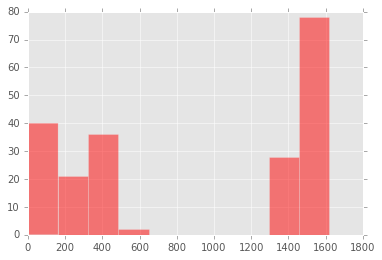

77984114 1373408814501 1373407520220 1294.2809999


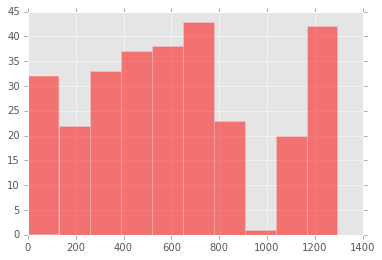

52041105 1373651240927 1373650083594 1157.33299994


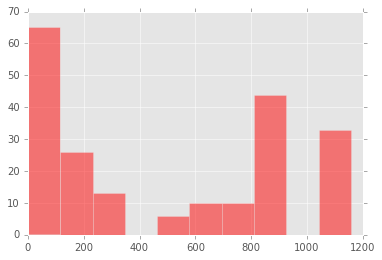

62898116 1373577819156 1373576374328 1444.82799983


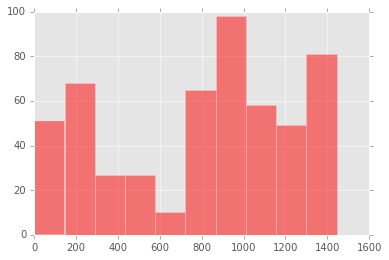

23112113 1373577967318 1373576599036 1368.28200006


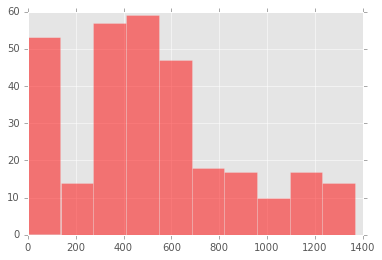

26225080 1373408836729 1373407231089 1605.6400001


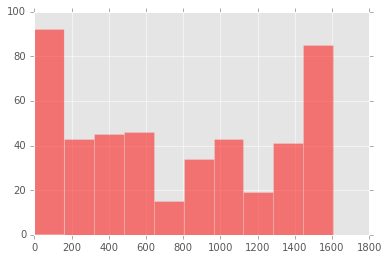

37842114 1373408234118 1373407243008 991.110000134


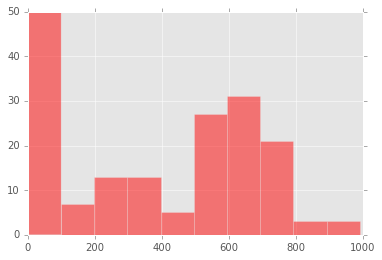

61117124 1363890970797 1363889410765 1560.03199983


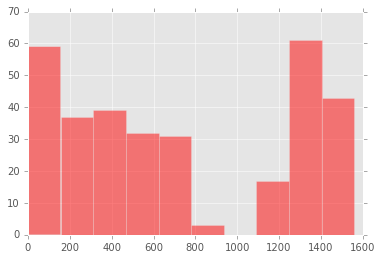

85298121 1373408795043 1373407199758 1595.28500009


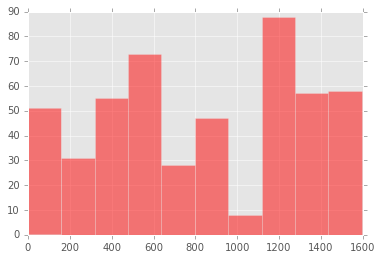

8775127 1363635046523 1363633460413 1586.1099999


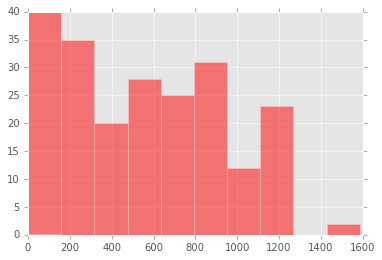

57521121 1373408709415 1373407238884 1470.5309999


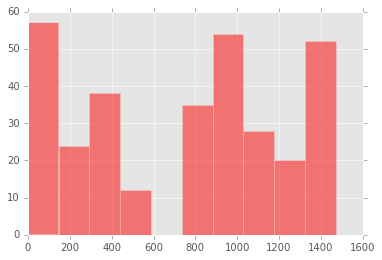

44827119 1373480978187 1373479375703 1602.48399997


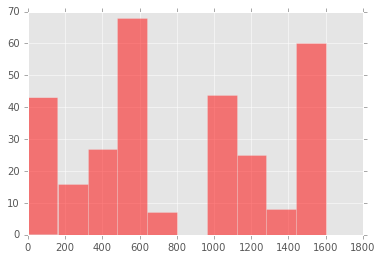

28582129 1363634820420 1363633582473 1237.94700003


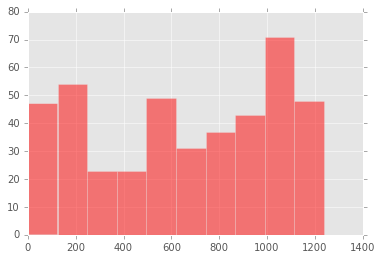

64687090 1373481015685 1373479382247 1633.43799996


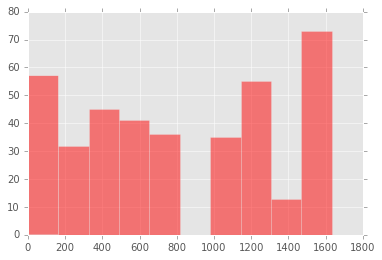

72794100 1373408790952 1373407255515 1535.4369998


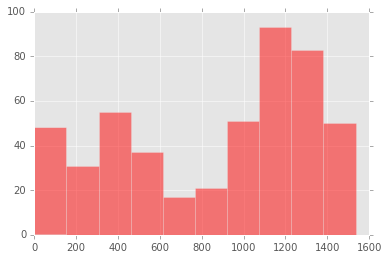

64944126 1363825955959 1363824382944 1573.0150001


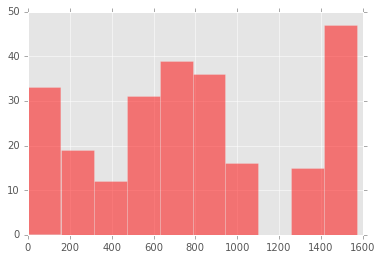

23


In [10]:
i=0
for student in students_Lpre:
    if  (max(df[df['student']==student]['Time Stamp'])-min(df[df['student']==student]['Time Stamp']))/1000.0<1660:
        print student, max(df[df['student']==student]['Time Stamp']),min(df[df['student']==student]['Time Stamp']),            max(df[df['student']==student]['Time Stamp'])/1000.0-min(df[df['student']==student]['Time Stamp'])/1000.0
        data = df[df['student'] == student]['Time Stamp']
        plt.hist([(x-min(data))/1000.0 for x in data],color ='r',alpha = 0.5)
        plt.show()
        plt.clf()
        i+=1
print i

length in time :
	T-test:	-0.797 	 p=0.428
	HL<LL:	547.0 	 p=0.0699
	HL>LL:	547.0 	 p=0.9315
1713.68136842 1771.88325


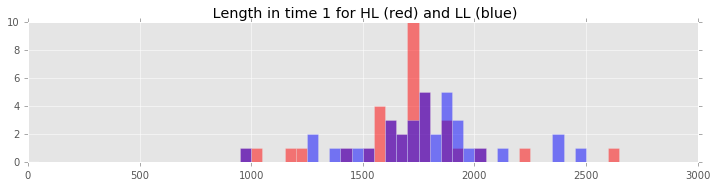

In [11]:
length_time_HL = [ (max(df[df['student']==student]['Time Stamp'])-min(df[df['student']==student]['Time Stamp']))/1000.0 for student in students_HL]
length_time_LL = [ (max(df[df['student']==student]['Time Stamp'])-min(df[df['student']==student]['Time Stamp']))/1000.0 for student in students_LL]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= int(max(max(length_time_HL),max(length_time_LL)))
bins = range(0,ymax+5,50)
plt.hist(length_time_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_time_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length in time 1 for HL (red) and LL (blue)")
perform_comparative_stats('length in time',length_time_HL,length_time_LL)
print np.mean(length_time_HL),np.mean(length_time_LL)

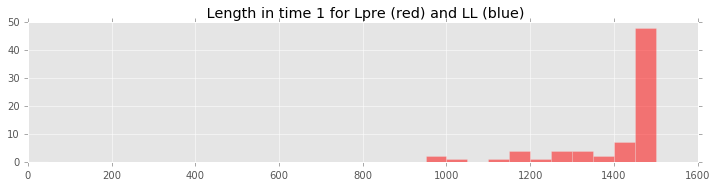

In [12]:
df2 =df[df['keep']]
length_time_Lpre = [ (max(df2[df2['student']==student]['Time Stamp'])-min(df2[df2['student']==student]['Time Stamp']))/1000.0 for student in students_Lpre]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= int(max(length_time_Lpre))
bins = range(0,ymax+5,50)
plt.hist(length_time_Lpre,color ='r',alpha = 0.5,bins = bins)
plt.title(" Length in time 1 for Lpre (red) and LL (blue)")

length in time 2 :
	T-test:	-1.114 	 p=0.2688
	HL<LL:	568.0 	 p=0.1058
	HL>LL:	568.0 	 p=0.8962


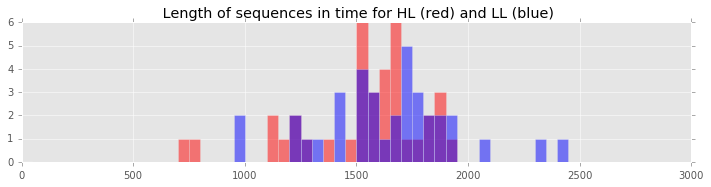

In [13]:
length_time_HL = [float(t[-1][0]+t[-1][1]) for student,t in time_coords_HL.iteritems()]
length_time_LL = [float(t[-1][0]+t[-1][1]) for student,t in time_coords_LL.iteritems()]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= int(max(max(length_time_HL),max(length_time_LL)))
bins = range(0,ymax+5,50)
plt.hist(length_time_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_time_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length of sequences in time for HL (red) and LL (blue)")
perform_comparative_stats('length in time 2',length_time_HL,length_time_LL)

length in time :
	T-test:	-2.052 	 p=0.044
	HL<LL:	496.0 	 p=0.0213
	HL>LL:	496.0 	 p=0.9793


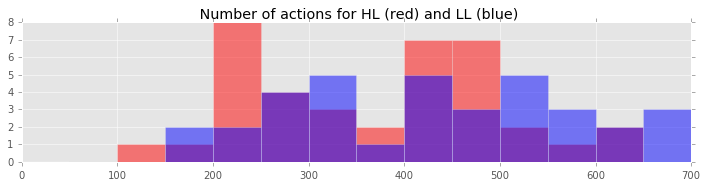

In [14]:
number_of_actions_HL = [len(list(df[df['student']==student]['Family'])) for student in students_HL]
number_of_actions_LL = [len(list(df[df['student']==student]['Family'])) for student in students_LL]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= int(max(max(number_of_actions_HL),max(number_of_actions_LL)))
bins = range(0,ymax+5,50)
plt.hist(number_of_actions_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(number_of_actions_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Number of actions for HL (red) and LL (blue)")
perform_comparative_stats('length in time',number_of_actions_HL,number_of_actions_LL)

length in blocks :
	T-test:	-1.937 	 p=0.0568
	HL<LL:	504.0 	 p=0.0261
	HL>LL:	504.0 	 p=0.9746


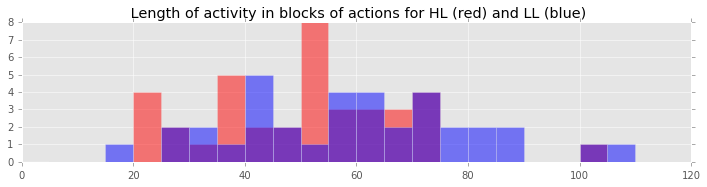

In [15]:
length_HL = [len(seq) for seq in blocks_HL.values()];length_LL = [len(seq) for seq in blocks_LL.values()]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= max(max(length_HL),max(length_LL))
bins = range(0,ymax+5,5)
plt.hist(length_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length of activity in blocks of actions for HL (red) and LL (blue)")
perform_comparative_stats('length in blocks',length_HL,length_LL)

Indeed they do not! We are going to have to normalize given the length of each student's sequence.

But first let's see how many blocks of each type of action students do.